In [2]:
import numpy as np
import cv2
%matplotlib inline

from skimage import color
from skimage import io

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image


In [3]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

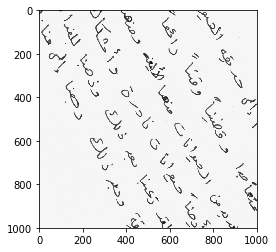

In [4]:
#Test importing and cropping image to center 

image = color.rgb2gray(mpimg.imread('data_prepared/1.png'))
plt.imshow(image, cmap='gray') # show image in grayscale

image = crop_center(image, 1000, 1000)
plt.imshow(image, cmap='gray') # show image in grayscale



In [5]:
def import_image_and_crop(datapath,crop_size=1000):
    ''' Read the image, convert it to grayscale, and use only the (crop_size x crop_size) center'''
    image = color.rgb2gray(mpimg.imread(datapath))
    assert(np.shape(image)[0]>crop_size and np.shape(image)[1]>crop_size),"Cant get center because image is too small"
    image = crop_center(image, crop_size, crop_size)
    return image

In [6]:
# import data

from os import listdir
from os.path import isfile, join
import random

crop_size = 500

onlyfiles = [f for f in listdir('data_prepared/') if isfile(join('data_prepared/', f))] # get list of datanames in folder

number_data = len(onlyfiles) - 1 # How many datafiles? One less because there is a list for the rotations
datanames = np.linspace(1,number_data,number_data)

X_train_pre = np.empty([number_data,crop_size,crop_size]) # create array to be filled, remember crop_size

for counter, number_of_file in enumerate(datanames):
    print(counter, end="\r")
    datapath = 'data_prepared/' + str(int(number_of_file))+'.png' # i know this is ugly
    X_train_pre[counter,:,:] = import_image_and_crop(datapath, crop_size)
    
    

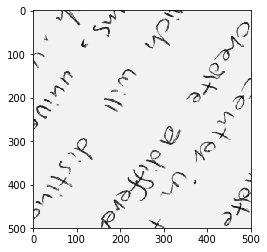

In [7]:
plt.imshow(X_train_pre[68,:,:], cmap='gray') # show image in grayscale

In [8]:
# load angle list
Y_train = np.loadtxt('data_prepared/angle_list', delimiter=',', unpack=True)
Y_train.reshape((number_data,1))
np.shape(Y_train)

(200,)

In [9]:
# weird thingy 
shape_ord = (crop_size, crop_size, 1)

X_train = X_train_pre

print(X_train.shape)


X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
print(np.shape(X_train))
X_train = X_train.astype('float32')

print(np.shape(X_train))

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

# -- Initializing the values for the convolution neural network

nb_epoch = 3  # kept very low! Please increase if you can use a GPU

batch_size = 50
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Flatten())
model.add(Dense(1, activation='softmax'))


model.compile(loss='mean_squared_error', optimizer='adam')
          
model.summary()

(200, 500, 500)
(200, 500, 500, 1)
(200, 500, 500, 1)


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7936128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7936129   
Total params: 7,936,449
Trainable params: 7,936,449
Non-trainable params: 0
_________________________________________________________________


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=20)

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Train on 140 samples, validate on 60 samples
Epoch 1/3
140/140 [==============================] - 279s 2s/step - loss: 38254.5564 - val_loss: 39296.7676
Epoch 2/3
 50/140 [=========>....................] - ETA: 3:56 - loss: 33611.8984